In [1]:
import numpy as np
import pylab as plt
import scipy.interpolate as interpolate
import scipy.special
import seaborn as sns

## Helper functions

In [2]:
def pole(m, z):
    return 1 / (m - z)

def analytic_dft(m, z, beta):
    prefactor = -1*(1 + np.exp(-m*beta))
    pole1 = 1/(np.exp(z-m) - 1)
    pole2 = 1/(np.exp(z+m) - 1)
    return prefactor * (pole1 + pole2)

def analytic_ft(z, m, beta, residue=1.0):
    prefactor = -1 #*(1 + np.exp(-m*beta))
    pole1 = 1/(z - m)
    pole2 = 1/(z + m)
    return prefactor * (pole1 + pole2)

def matsubara(beta, boson=False):
    n = np.arange(beta)
    if boson:
         return 2*n*np.pi/beta * 1j
    return (2*n+1)*np.pi/beta * 1j

def moebius(z):
    return (z - 1j)/(z + 1j)

def h(z):
    return moebius(z)

def hstar(z):
    return np.conjugate(h(z))

def build_pick(y, c):
    if len(y) != len(c):
        raise ValueError("Mismatched shapes?")
    beta = len(y)
    arr = np.zeros((beta, beta), dtype=complex)
    for i in range(beta):
        for j in range(beta):
            up = (1 - h(c[i])*hstar(c[j]))
            down = (1 - h(y[i])*hstar(y[j]))
            if down == 0:
                arr[i,j] = np.nan
            else:
                arr[i,j] = up/down
    return arr
    
def build_bspline(x, y):
    t, c, k = interpolate.splrep(x, y, s=0, k=4)
    bspline = interpolate.BSpline(t, c, k, extrapolate=True)
    return bspline    

def mirror(y, x=None, ax=None, label=None, color=None):
    """
    Makes a "mirror" plot, where negative values are mirrored to be positive.
    Positive (negative) values appear with circles (squares) for markers.
    """
    if ax is None:
        _, ax = plt.subplots(1)
    if x is None:
        x = np.arange(len(y))
    if len(x) != len(y):
        raise ValueError(
            f"Size mismatch between x and y: len(x)={len(x)}, len(y)={len(y)}")
    neg = y < 0
    pos = ~neg
    if pos.any():
        ax.errorbar(x[pos], y[pos], fmt='o', color=color, label=label)
        color = ax.lines[-1].get_color()  # match color
    if neg.any():
        ax.errorbar(x[neg], -y[neg], fmt='s', color=color,
                 markerfacecolor='none', markeredgewidth=2)
    return ax

def effective_mass(data):
    """
    Computes the effective mass analytically using the following formula
    (which I first learned about from Evan Weinberg):

    meff = ArcCosh( (C(t+1)+ C(t-1)) / C(t) )

    This method correctly accounts for contributions both from forward- and
    backward-propagating states. It also work without modification both for
    Cosh-like and Sinh-like correlators.
    """
    cosh_m = (data[2:] + data[:-2]) / (2.0 * data[1:-1])
    meff = np.zeros(len(cosh_m))
    # The domain of arccosh is [1, Infinity).
    # Set entries outside of the domain to nans.
    domain = (cosh_m > 1)
    meff[domain] = np.arccosh(cosh_m[domain])
    meff[~domain] = np.nan
    return meff


# Numerical Fourier transform

This checks our ability to move from Euclidean time to Euclidean frequency

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: Compl

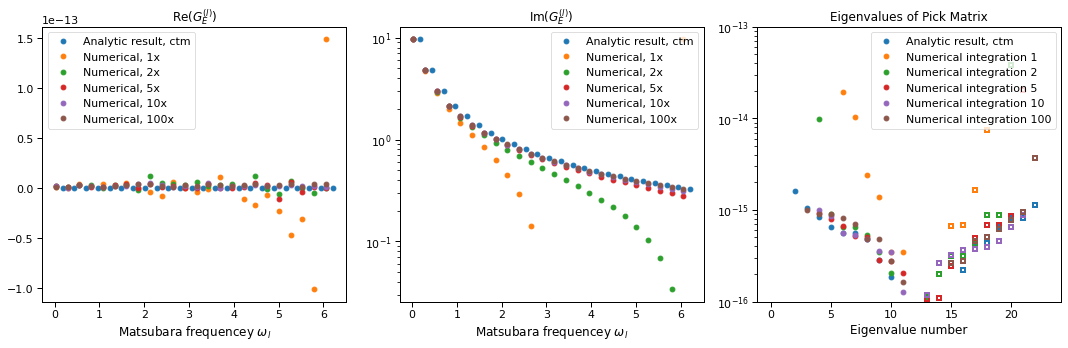

In [3]:
beta = 24
omega = np.pi/beta * (2*np.arange(beta) + 1)  # fermionic Matsubara frequencies
E0 = 0.1

with sns.plotting_context("paper", font_scale=12/9.6):
    fig, axarr = plt.subplots(ncols=3, figsize=(15,5))
    ax1, ax2, ax3 = axarr

    # Analytic result, continuum limit 
    tmp1 = np.zeros(beta, dtype=complex)
    for l, omega_l in enumerate(omega):
        tmp1[l] = 2*1j*omega_l/(omega_l**2 + E0**2)
    ax1.errorbar(x=omega+0.05, y=tmp1.real, fmt='o', label='Analytic result, ctm')
    ax2.errorbar(x=omega+0.05, y=tmp1.imag, fmt='o', label='Analytic result, ctm')

    pick = build_pick(1j*omega[1:], tmp1[1:])
    vals = np.linalg.eigvals(pick)
    vals = np.sort(vals)[::-1]
    mirror(x=np.arange(len(vals)), y=vals, ax=ax3, label=f'Analytic result, ctm', color=ax1.lines[-1].get_color())

    # Numerical integral to compute continuum Fourier coefficients
    y = np.zeros(len(omega), dtype=complex)
    for factor in [1,2,5,10,100]:
        for l, omega_l in enumerate(omega):
            x = np.linspace(0, beta, num=beta*factor)
            corr = (np.exp(-E0*x) + np.exp(-E0*(beta-x)))/ (1 + np.exp(-beta*E0))
            phase = np.exp(1j*omega_l*x)
            re = np.trapz(x=x, y=(corr*phase).real)
            im = np.trapz(x=x, y=(corr*phase).imag)
            y[l] = re + 1j*im

        ax1.errorbar(omega-0.1, y.real, fmt='o', label=f'Numerical, {factor}x')
        ax2.errorbar(omega-0.1, y.imag, fmt='o', label=f'Numerical, {factor}x')    

        # Check positivity of the Pick matrix
        pick = build_pick(omega*1j, y)[:,:]
        vals = np.linalg.eigvals(pick)
        vals = np.sort(vals)[::-1]
        mirror(vals, ax=ax3, label=f'Numerical integration {factor}', color=ax1.lines[-1].get_color())

    ax2.set_yscale("log")
    ax2.set_ylim(bottom=-1e-3)    

    ax3.set_yscale("log")
    ax3.set_ylim(bottom=1e-16, top=1e-13)
    ax1.legend()
    ax2.legend()
    ax3.legend()

    ax1.set_title(r"Re($G_E^{(l)}$)")
    ax2.set_title(r"Im($G_E^{(l)}$)")
    ax3.set_title("Eigenvalues of Pick Matrix")

    ax1.set_xlabel(r"Matsubara frequencey $\omega_l$")
    ax2.set_xlabel(r"Matsubara frequencey $\omega_l$")
    ax3.set_xlabel(r"Eigenvalue number")


    fig.tight_layout()



# Numerical Laplace and Fourier transform

This checks our ability to move from spectral densities to Euclidean frequency

Text(0.5, 0, 'Matsubara frequencey $\\omega_l$')

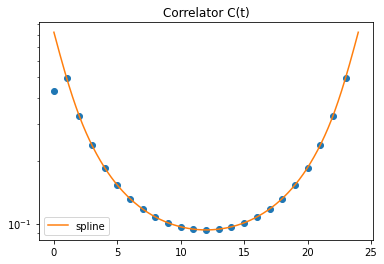

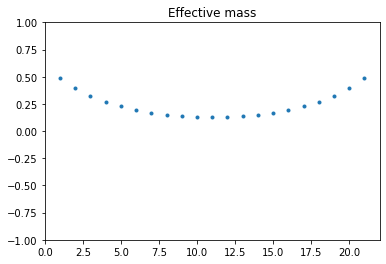

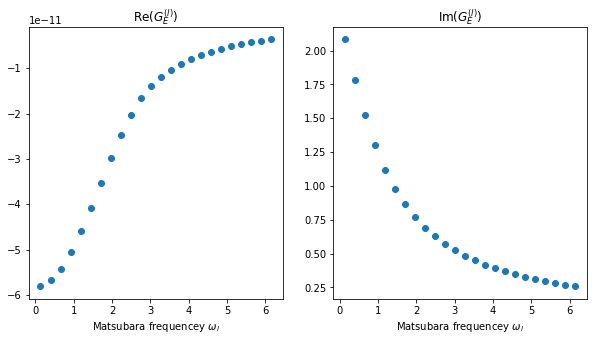

In [4]:
def kernel(omega, beta, tau):
    return (np.exp(-omega*tau) + np.exp(-omega*(beta-tau)))/(1 + np.exp(-beta*tau))

def gaussian(x, x0, sigma):
    return np.exp(-0.5*(x-x0)**2/sigma**2) / (np.sqrt(2*np.pi)*sigma)

beta = 24
E0 = 0.5
sigma = 0.5

omega = np.linspace(0, 10, num=1000)
rho = gaussian(omega, E0, sigma)

corr = np.zeros(beta)

for tau in np.arange(beta):
    kern = kernel(omega, beta, tau)
    corr[tau] = np.trapz(x=omega, y=kern*rho)

corr_spline = build_bspline(np.arange(1,beta), corr[1:])
    
# Plot the correlator
fig, ax = plt.subplots(1)
ax.errorbar(np.arange(beta), corr, fmt='o')
xfine = np.linspace(0, beta, num=1000)
ax.errorbar(xfine, corr_spline(xfine), label='spline')
ax.set_yscale("log")            
ax.set_title("Correlator C(t)")
ax.legend()
    
# Plot the effective mass
fig, ax = plt.subplots(1)
y = effective_mass(corr)
x = np.arange(len(y))
ax.errorbar(x, y, fmt='.')
ax.set_ylim(-1, 1)
ax.set_title("Effective mass")


# Compute the Fourier transform at the fermionic Matsubara frequencies
omega = (2*np.arange(beta) + 1) * np.pi / beta

factor = 10  # refinement factor for numerical integration of Fourier coefficients
corr_ft = np.zeros(len(omega), dtype=complex)
for l, omega_l in enumerate(omega):
    x = np.linspace(0, beta, num=beta*factor)
    y = corr_spline(x)
    phase = np.exp(1j*omega_l*x)
    re = np.trapz(x=x, y=(y*phase).real)
    im = np.trapz(x=x, y=(y*phase).imag)
    corr_ft[l] = re + 1j*im

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
ax1.errorbar(x=omega, y=corr_ft.real, fmt='o')
ax2.errorbar(x=omega, y=corr_ft.imag, fmt='o')

ax1.set_title(r"Re($G_E^{(l)}$)")
ax2.set_title(r"Im($G_E^{(l)}$)")

ax1.set_xlabel(r"Matsubara frequencey $\omega_l$")
ax2.set_xlabel(r"Matsubara frequencey $\omega_l$")




    
    
    
    
